In [4]:
from abc import ABC, abstractmethod
import numpy as np
import pickle
import pandas as pd

class InterfaceEnvironment(ABC):
    
    @abstractmethod
    def __init__(self):
        pass
    
    @property
    @abstractmethod
    def states(self):
        """The representation of the state space"""
        pass
    
    
    @abstractmethod
    def step(self, action):
        """Takes a step. Uses action for the step
        
        returns
        =======
        
        
        """
        pass
    
    @abstractmethod
    def reset(self):
        """resets environment. Defaults back to starting period. 
        reset method also can take a state (used for solving the model)"""
        pass
    
    

In [72]:
with open('..//data//fertility.pkl', 'rb' ) as f:
    fertility_data = pickle.load(f)
    
with open('..//data//men_wage_path.pkl', 'rb' ) as f:
    men_wage_path_data = pickle.load(f)
    
with open('..//data//men_hours_empirical', 'rb') as f:
    men_hours_data = pickle.load(f)
    
men_salary_path = np.array(men_hours_data * men_wage_path_data * 46)

In [73]:
# calculating scales
Q_mean, Q_scale = (60 + 18)*0.5, (60 - 18)*0.5
K_mean, K_scale = (0 + 5)*0.5, (5 - 0)*0.5
G_mean, G_scale = (0 + 5)*0.5, (5 - 0)*0.5
Z_mean, Z_scale = (-200 + 200), (200 - (-200))*0.5

beta_K_mean, beta_K_scale =(-5 + 5)*0.5, (5 - (-5))*0.5
beta_L_mean, beta_L_scale =(-5 + 5)*0.5, (5 - (-5))*0.5

In [403]:
def scale_states(Q, G, K, Z, beta_K, beta_L):
    Q = (Q - Q_mean )/ Q_scale
    G = (G - Q_mean )/ G_scale
    K = (K - K_mean )/ K_scale
    Z = (Z - Z_mean )/ Z_scale
    
    beta_K = (beta_K - beta_K_mean )/ beta_K_scale
    beta_L = (beta_L - beta_L_mean )/ beta_L_scale
    return np.array([[Q, G, K, Z, beta_K, beta_L]])
    
class EnvironmentModel1(InterfaceEnvironment):
    
    """
    Ordering of items
    states: Q, M, K, W
    shocks: epsilon, rho, psi
    """
    
    DEFAULT_Q = 18
    DEFAULT_G = 2.0
    DEFAULT_K = 0
    DEFAULT_Z = 0.0
    
    def __init__(self, sigma_epsilon, S_min, eta_G, eta_G_sq, alpha, delta, beta_K, beta_L):
        
        #parameters
        self.sigma_epsilon = sigma_epsilon
        self.S_min = S_min
        self.eta_G = eta_G
        self.eta_G_sq = eta_G_sq
        self.alpha = alpha
        self.delta = delta
        
        # The parameters that need to be tuned!
        self.beta_K = beta_K
        self.beta_L = beta_L

        #states
        self.Q = self.DEFAULT_Q
        self.G = self.DEFAULT_G
        self.K = self.DEFAULT_K
        self.Z = self.DEFAULT_Z
        
    def __repr__(self):
        return f"(Q: {self.Q}, G: {self.G}, K: {self.K}, Z: {self.Z})"
    
    @property
    def states(self):
        return scale_states(self.Q, self.G, self.K, self.Z, self.beta_K, self.beta_L)
    

    
    def reset(self, states=None, parameters=None):
        """Expect states given as: (Q, G, K, Z) """
        if states is not None:
            Q, G, K, Z = states[0], states[1], states[2], states[3]
            self.Q = Q
            self.G = G
            self.K = K
            self.Z = Z
        else:
            self.Q = self.DEFAULT_Q
            self.G = self.DEFAULT_G
            self.K = self.DEFAULT_K
            self.Z = self.DEFAULT_Z
            
        if parameters is not None:
            for key, val in parameters.items():
                setattr(self, key, val)
        
    def step(self, action, shocks=None, parameters=None):
        """
        shocks:
            (epsilon, psi) <- that order
        """
        if shocks is None:
             shocks = self.draw_shocks()
        epsilon, psi = shocks

        if parameters is not None:
            for key, val in parameters.items():
                setattr(self, key, val)
        # remember action: hours (H)
    
        ### transition
        self.calc_Q()
        self.calc_Z(epsilon)
        self.calc_K(psi)
        
        ### model dynamic
        L = self.calc_L(action)
        
        # wage/salary process
        log_S_tilde = self.calc_log_S_tilde()
        S = self.calc_S(log_S_tilde)
        W = self.calc_W(S, action)

        # husband income
        M = self.calc_M()
        
        # household income
        Y = self.calc_Y(W, M)
        
        utility = self.calc_U(L, Y)
        
        self.calc_G(action)


        # this might be changed
        done = self.calc_stops()
        
        _info = f'Y: {Y}, L: {L}, W: {W}, S: {S}, M: {M}' 
        if done is True:
            return self.states, utility, True, _info 
        
        return self.states, utility, False, _info

    
    #model dynamic
    def calc_log_S_tilde(self):
        return self.alpha + self.eta_G * self.G + self.eta_G_sq * self.G**2
    
    def calc_U(self, L, Y):
        u = self.beta_K * np.log(self.K + 1) + self.beta_L * np.log(L + 1) + np.log(Y + 1)
        if np.isnan(u):
            raise Exception(f"K: {self.K}, L: {L}, Y: {Y}")
        return u
    
    def calc_W(self, S, H):
        return S * H * 46
    
    def calc_M(self):
        # use data (non parametric)
        # return 450000
        return men_salary_path[self.Q]
    
    def calc_Y(self, W, M ):
        return W + M
    
    def calc_L(self, hours):
        return 46 * (7 * 24 - hours)
    
    def calc_stops(self):
        # stops the model (returns done flag)
        if self.Q > 60:
            return True
        return False
    
    def calc_K(self, psi):
        if self.K < 5:
            self.K = self.K + psi
    
    def calc_S(self, log_S_tilde):
        _S = np.exp(log_S_tilde)+ self.Z
        return max(self.S_min, _S)
        #return 190
            
    def calc_Q(self):
        self.Q = self.Q + 1
    
    def calc_G(self, H):
        self.G = self.G * (1 - self.delta) + H/37
        
    def calc_Z(self, epsilon):
        self.Z = self.Z + epsilon
    
    # def shocks
    def draw_shocks(self):
        return (self.draw_epsilon(), self.draw_psi())
        
    def draw_epsilon(self):
        return np.random.normal(0, self.sigma_epsilon)
    
    def get_p_psi(self):
        return fertility_data[self.Q]
    
    def draw_psi(self):
        p_psi = self.get_p_psi()
        return np.random.binomial(1, p_psi)

    # helpers
    @property
    def observation_space(self):
        return self.states
    
    @property
    def action_space(self):
        return 4

In [357]:
from itertools import product
def create_state_grid():
    Q, K, G, Z, = reversed(list(range(18, 61))), list(range(0,6)), np.linspace(0, 6, num=13), np.linspace(-200, 200, 17)
    return list(product(Q, G, K, Z))
    

In [358]:
parameters = {
    'beta_K' : 1,
    'beta_L' : 1,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11
}
env = EnvironmentModel1(**parameters)

In [359]:
ACTIONS = [0, 25, 37, 45]
def translate_action(a):
    return ACTIONS[a]

In [584]:
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        #with tf.device('/gpu:0'):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        states, targets_f = [], []
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target 
            # Filtering out states and targets for training
            states.append(state[0])
            targets_f.append(target_f[0])
        history = self.model.fit(np.array(states), np.array(targets_f), epochs=1, verbose=0)
        # Keeping track of loss
        loss = history.history['loss'][0]
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return loss

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

# values for reward scaler is found by tuning parameters so r_scaled in [-1, 1]
def reward_scaler(r, beta_K, beta_L):
    return (r - 13.5 - ( beta_K * 0.9) - (beta_L * 8.64)) / 3
        
parameters = {
    'beta_K' : 1,
    'beta_L' : 1.55,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11
}
env = EnvironmentModel1(**parameters)

state_size = env.observation_space.shape[1]
action_size = 4
agent = DQNAgent(state_size, action_size)
# agent.load("./save/cartpole-dqn.h5")
done = False
batch_size = 32
EPISODES = 500


for e in range(EPISODES):
    env.reset()
    state = env.states
    all_rewards = list()
    for time in range(500):
        action = agent.act(state)
        _action = translate_action(action)
        next_state, reward, done, _ = env.step(_action)
        scaled_reward = reward_scaler(reward, env.beta_K, env.beta_L)
        if time  == 0:
            print('reward 0:' + str(reward) + '   ' + str(scaled_reward))
        all_rewards.append( reward )
        agent.memorize(state, action, scaled_reward , next_state, done)
        state = next_state
        if done:
            print(reward)
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, EPISODES, np.mean(all_rewards), agent.epsilon))
            break
        if len(agent.memory) > batch_size:
            # Logging training loss every 10 timesteps
            if time % 5 == 0:
                loss = agent.replay(batch_size)
                print("    episode: {}/{}, time: {}, loss: {:.4f}"
                    .format(e, EPISODES, time, loss))  

reward 0:25.53956079578297   -0.7508130680723445
    episode: 0/500, time: 35, loss: 4.4792


KeyboardInterrupt: 

7 Y: 612627.2517650829, L: 7406, W: 84051.30658670714, S: 261.0289024431899, M: 528575.9451783758
17 Y: 752876.4961705373, L: 6946, W: 224300.55099216144, S: 286.8293490948356, M: 528575.9451783758
27 Y: 857370.3159569353, L: 6486, W: 328794.3707785595, S: 264.72976713249557, M: 528575.9451783758
37 Y: 972433.2433507647, L: 6026, W: 443857.29817238887, S: 260.78572160539886, M: 528575.9451783758
47 Y: 1138631.6126705678, L: 5566, W: 610055.6674921921, S: 282.171909108322, M: 528575.9451783758
57 Y: 1168373.1602079417, L: 5106, W: 639797.215029566, S: 244.0111422690946, M: 528575.9451783758
67 Y: 1317350.6880690577, L: 4646, W: 788774.7428906817, S: 255.92950775168129, M: 528575.9451783758
77 Y: 1508498.557163774, L: 4186, W: 979922.6119853982, S: 276.65799322004466, M: 528575.9451783758
87 Y: 1573874.9874440024, L: 3726, W: 1045299.0422656266, S: 261.19416348466433, M: 528575.9451783758
97 Y: 1672414.2238540156, L: 3266, W: 1143838.2786756398, S: 256.3510261487315, M: 528575.9451783758

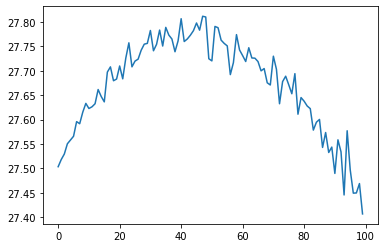

In [461]:
res = list()
for act in range(100):
    env.reset(states=(45,4, 5, 15))
    s, r, done, _ = env.step(act)
    res.append(r)
    if (act + 3) %10 ==0:
        print(act, _)
        
print('\n',np.argmax(res))
plt.plot(res)

In [508]:
rewards_history, action_history = list(), list()
EPISODES = 150
agent.epsilon=0.0

for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        action = agent.act(state)
        _action = translate_action(action)
        next_state, reward, done, _ = env.step(_action)
        scaled_reward = (reward - 24 ) / 5

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            #print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, np.mean(rewards_history), agent.epsilon))
            break

df_DQAgent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])
df_DQAgent_action = pd.DataFrame(action_history, columns=['actions', 'episode', 'Q'])

episode: 0/150, score: 21.87418132247864, e: 0.0
episode: 1/150, score: 22.04147106483781, e: 0.0
episode: 2/150, score: 22.229543573695725, e: 0.0
episode: 3/150, score: 22.342116532886514, e: 0.0
episode: 4/150, score: 22.52164512711182, e: 0.0
episode: 5/150, score: 22.664006798759438, e: 0.0
episode: 6/150, score: 22.845656832922216, e: 0.0
episode: 7/150, score: 23.019197079857125, e: 0.0
episode: 8/150, score: 23.1865461730692, e: 0.0
episode: 9/150, score: 23.363442495304053, e: 0.0
episode: 10/150, score: 23.525669779406513, e: 0.0
episode: 11/150, score: 23.69393533461404, e: 0.0
episode: 12/150, score: 23.869802032602724, e: 0.0
episode: 13/150, score: 24.03921521447143, e: 0.0
episode: 14/150, score: 24.20095573901025, e: 0.0
episode: 15/150, score: 24.375257395077654, e: 0.0
episode: 16/150, score: 24.538801689327606, e: 0.0
episode: 17/150, score: 24.712500462966652, e: 0.0
episode: 18/150, score: 24.874505995710415, e: 0.0
episode: 19/150, score: 25.046351194277864, e: 0.

In [509]:
def random_action():
    act = np.random.randint(0, 4)
    return [0, 25, 37, 45][act]


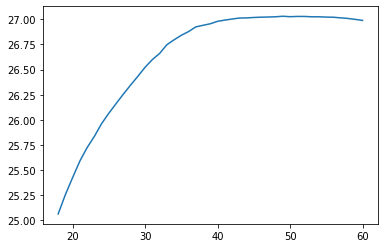

In [510]:
plt.plot(df_DQAgent.drop('episode', axis=1).groupby('Q').mean())

In [520]:
rewards_history, action_history = list(), list()
EPISODES = 150
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = random_action()
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break
            
df_random_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [525]:
rewards_history, action_history = list(), list()
EPISODES = 150
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 0
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_0_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [526]:
rewards_history, action_history = list(), list()
EPISODES = 150
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 37
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_37_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [527]:
rewards_history, action_history = list(), list()
EPISODES = 150
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 45
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_45_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

episode: 0/150, score: 22.006241567859885, e: 0.0
episode: 1/150, score: 22.154179145892222, e: 0.0
episode: 2/150, score: 22.281225164922215, e: 0.0
episode: 3/150, score: 22.43748569385937, e: 0.0
episode: 4/150, score: 22.617044567326822, e: 0.0
episode: 5/150, score: 22.768502525022686, e: 0.0
episode: 6/150, score: 22.90111306392761, e: 0.0
episode: 7/150, score: 23.059603079959935, e: 0.0
episode: 8/150, score: 23.256067767030608, e: 0.0
episode: 9/150, score: 23.43708311294861, e: 0.0
episode: 10/150, score: 23.602075564726785, e: 0.0
episode: 11/150, score: 23.770045133286413, e: 0.0
episode: 12/150, score: 23.952806181665668, e: 0.0
episode: 13/150, score: 24.10233020769076, e: 0.0
episode: 14/150, score: 24.262652712830583, e: 0.0
episode: 15/150, score: 24.427210004666122, e: 0.0
episode: 16/150, score: 24.594182986833175, e: 0.0
episode: 17/150, score: 24.772521133500156, e: 0.0
episode: 18/150, score: 24.932863392797447, e: 0.0
episode: 19/150, score: 25.105320211437647, e

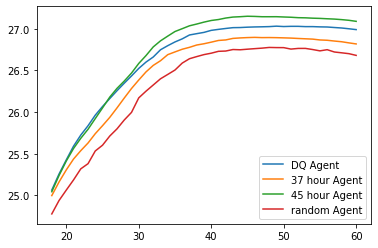

In [529]:
#plt.plot(df_random_agent.drop('episode', axis=1).groupby('Q').mean(), label='Random Agent')
plt.plot(df_DQAgent.drop('episode', axis=1).groupby('Q').mean(), label='DQ Agent')
plt.plot(df_37_agent.drop('episode', axis=1).groupby('Q').mean(), label='37 hour Agent')
plt.plot(df_45_agent.drop('episode', axis=1).groupby('Q').mean(), label='45 hour Agent')
plt.plot(df_random_agent.drop('episode', axis=1).groupby('Q').mean(), label='random Agent')


plt.legend()

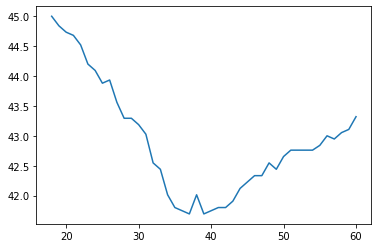

In [530]:
plt.plot(df_DQAgent_action.drop('episode', axis=1).groupby('Q').mean())